# DE LAGREVOL Regis & LI Ludovic

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import bokeh
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import io
from google.colab import files
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import warnings
import requests
warnings.filterwarnings('ignore')

### Dataset

In [2]:
uploaded = files.upload()

data = pd.read_csv(io.BytesIO(uploaded['SkillCraft1_Dataset.csv']))
data.rename(columns={'GameID': 'GamerID'}, inplace=True) #erreur sur le nom de la colonne
data

Saving SkillCraft1_Dataset.csv to SkillCraft1_Dataset.csv


,GamerID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.000000,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


### Nettoyage du dataset

In [3]:
data.replace("?",np.nan,inplace=True) 
data.dropna(inplace=True) # perte de 57 lignes, négligeable
data

,GamerID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,9261,4,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3336,9264,5,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3337,9265,4,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3338,9270,3,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


In [4]:
data.dtypes

GamerID                   int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [5]:
data["Age"]=pd.to_numeric(data["Age"])
data["HoursPerWeek"]=pd.to_numeric(data["HoursPerWeek"])
data["TotalHours"]=pd.to_numeric(data["TotalHours"])

In [6]:
#data[data["TotalHours"]==1000000]

In [7]:
data.dtypes

GamerID                   int64
LeagueIndex               int64
Age                       int64
HoursPerWeek              int64
TotalHours                int64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [8]:
data.describe()

,GamerID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,4719.552127,4.120731,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,2656.919630,1.448170,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2423.250000,3.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,4788.000000,4.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,6994.750000,5.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,9271.000000,7.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [9]:
data_incoherente=data[["TotalHours","Age"]]
data_incoherente["TotalHours_parAn"]=data_incoherente["TotalHours"]/8760
data_incoherente.loc[data_incoherente["TotalHours_parAn"]>data_incoherente["Age"]]

#un joueur a joué 24h/24 pendant 114 ans alors qu'il a 18 ans

,TotalHours,Age,TotalHours_parAn
1793,1000000,18,114.155251


In [10]:
data = data[data['TotalHours']!=1000000]
data

,GamerID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,9261,4,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3336,9264,5,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3337,9265,4,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3338,9270,3,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


### Matrice de corrélation

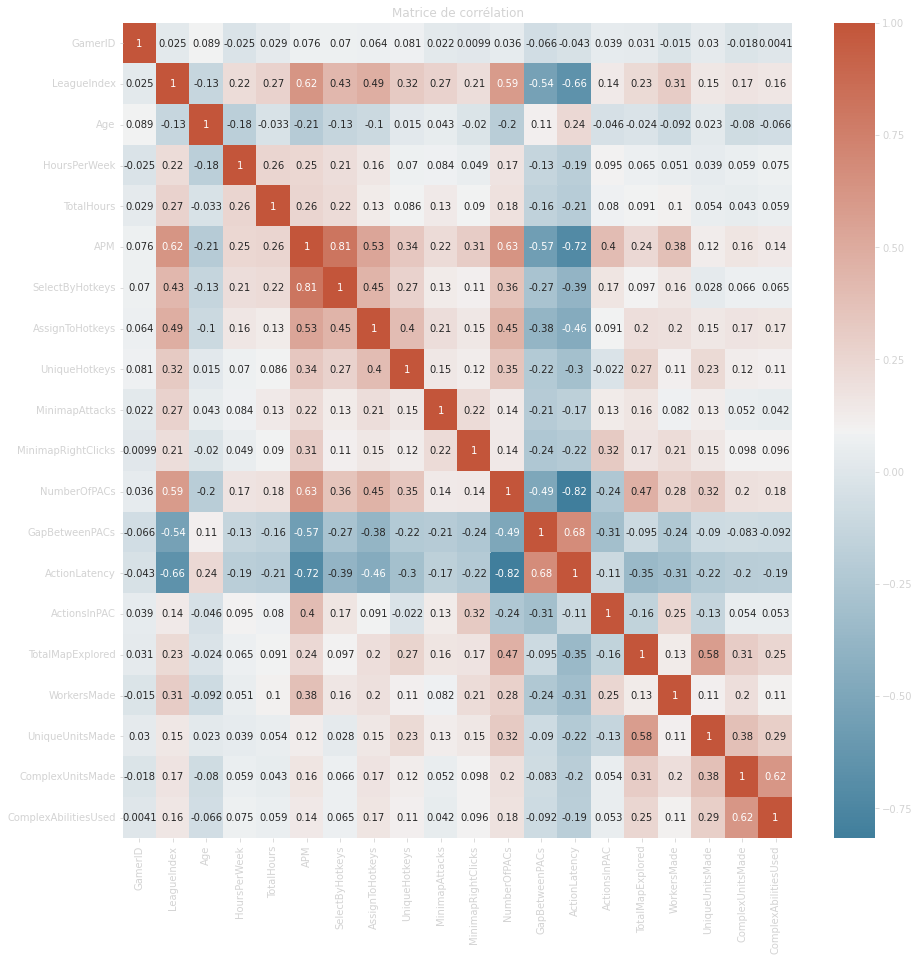

In [11]:
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr=data.corr()
heatmap=sns.heatmap(corr,cmap=cmap,annot=True)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors="lightgray")
ax.tick_params(axis='x', colors="lightgray")
ax.tick_params(axis='y', colors="lightgray")
plt.title("Matrice de corrélation",color="lightgray")
plt.show()
#plt.savefig("abc.png",transparent=True)
#files.download("abc.png") 

### Treemap

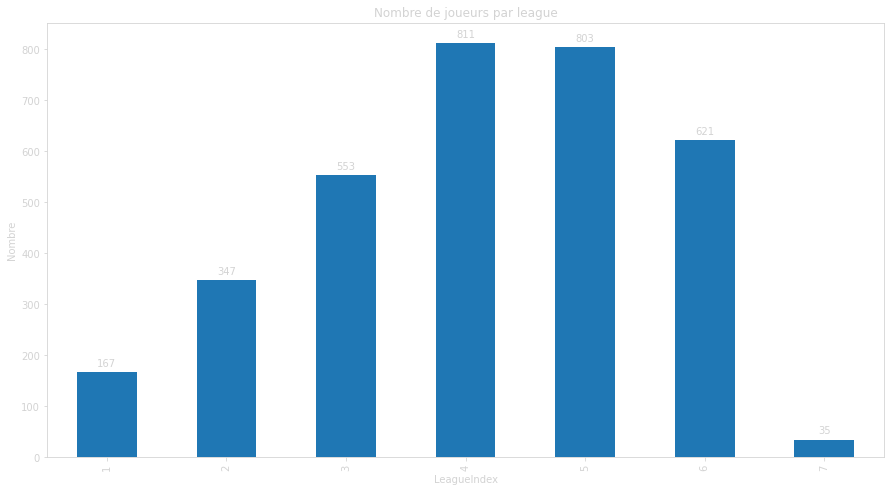

In [12]:
f, ax = plt.subplots(figsize=(15,8))
ax.tick_params(color="lightgray",labelcolor="lightgray")
for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
data["LeagueIndex"].value_counts()[[1,2,3,4,5,6,7]].plot.bar()
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',color="lightgray")
plt.title("Nombre de joueurs par league",color="lightgray")
plt.xlabel("LeagueIndex",color="lightgray")
plt.ylabel("Nombre",color="lightgray")
plt.show()
#plt.savefig("abc.png",transparent=True)
#files.download("abc.png") 

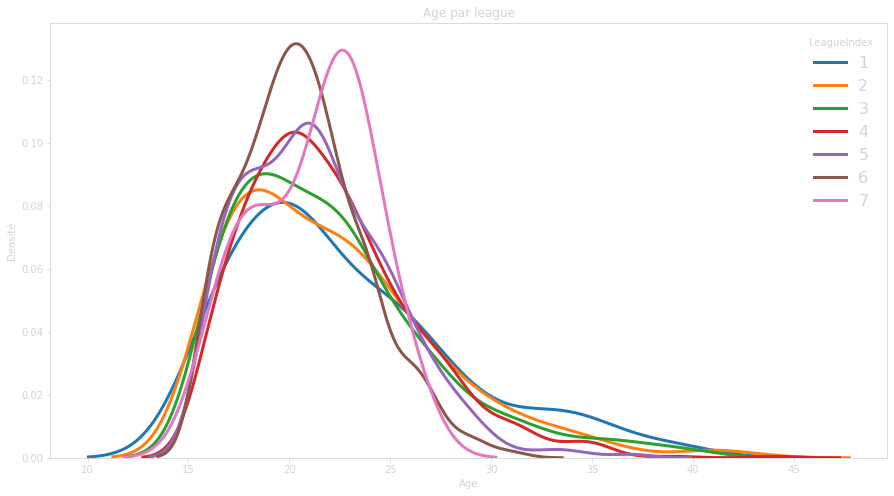

In [13]:
labels = [1,2,3,4,5,6,7,8]

f, ax = plt.subplots(figsize=(15,8))
for label in labels:
    subset = data[data['LeagueIndex'] == label]
    sns.distplot(subset['Age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = label)

leg=plt.legend(prop={'size': 16}, title = 'LeagueIndex',framealpha=0)
plt.setp(leg.get_title(), color='lightgray')
plt.title('Age par league',color="lightgray")
plt.xlabel('Age',color="lightgray")
plt.ylabel('Densité',color="lightgray")
ax.tick_params(color="lightgray",labelcolor="lightgray")
for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
for text in leg.get_texts():
  text.set_color("lightgray")
plt.show()
#plt.savefig("abc.png",transparent=True)
#files.download("abc.png") 

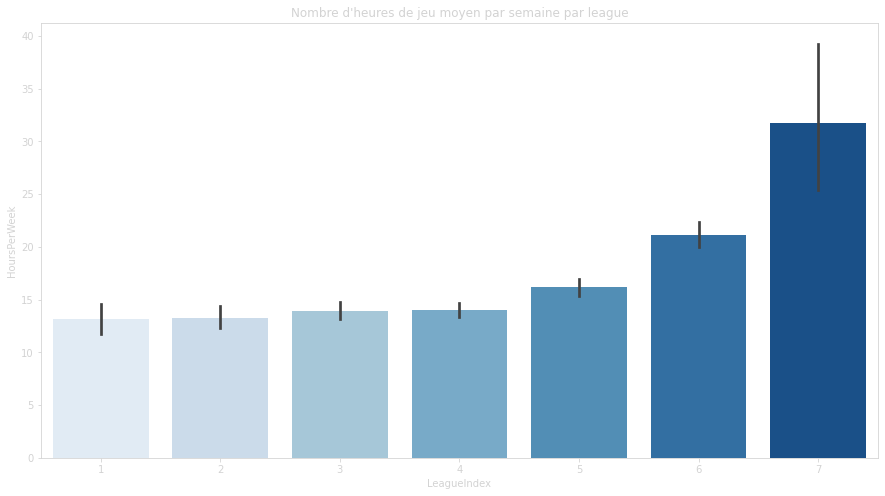

In [14]:
f, ax = plt.subplots(figsize=(15,8))
ax.tick_params(color="lightgray",labelcolor="lightgray")
for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
plt.xlabel(xlabel="LeagueIndex",color="lightgray")
plt.ylabel(ylabel="Heures par semaine",color="lightgray")
sns.barplot(x='LeagueIndex', y='HoursPerWeek', data=data, palette="Blues").set_title("Nombre d'heures de jeu moyen par semaine par league",color="lightgray")
plt.show()

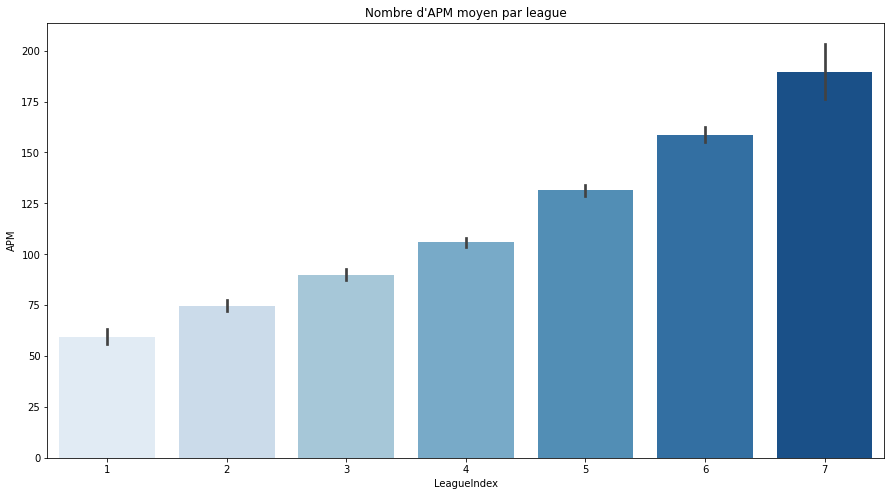

In [15]:
f, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='LeagueIndex', y='APM', data=data, palette="Blues").set_title("Nombre d'APM moyen par league")
plt.show()

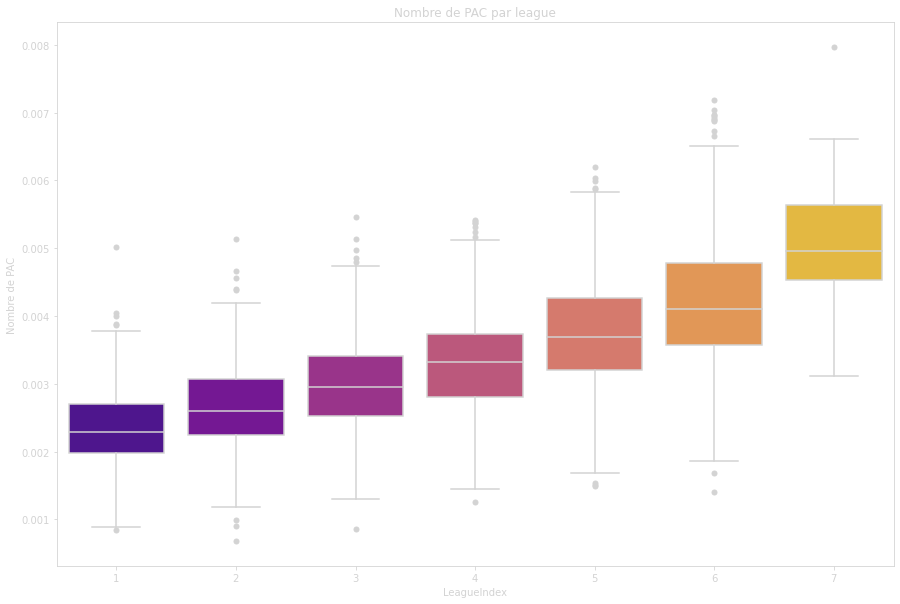

In [16]:
f, ax = plt.subplots(figsize=(15,10))
ax.tick_params(color="lightgray",labelcolor="lightgray")
for spine in ax.spines.values():
        spine.set_edgecolor("lightgray")
flierprops = dict(marker='o', markersize=5,markerfacecolor='lightgray',markeredgecolor='lightgray')
sns.boxplot(x = "LeagueIndex", y = "NumberOfPACs", data = data,palette="plasma",flierprops=flierprops).set_title("Nombre de PAC par league",color="lightgray")
for i,box in enumerate(ax.artists):
    box.set_edgecolor('lightgray')
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('lightgray')
plt.xlabel(xlabel="LeagueIndex",color="lightgray")
plt.ylabel(ylabel="Nombre de PAC",color="lightgray")
plt.show()
#plt.savefig("abc.png",transparent=True)
#files.download("abc.png") 

### Standardisation des données

In [17]:
data_scaled = StandardScaler().fit_transform(data)
data_scaled_df=pd.DataFrame(data_scaled, columns=data.columns)
data_scaled_df

,GamerID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,-1.756712,0.607374,1.271675,-0.493753,2.731727,0.607854,-0.106552,-0.687610,1.150241,0.100974,0.033639,1.467259,-0.471974,-1.226970,-0.343856,0.791033,0.702772,-0.291123,-0.538113,-0.534482
1,-1.755583,0.607374,0.320626,-0.493753,5.067574,0.306224,-0.151381,-0.498154,-0.135496,1.259670,0.145240,0.905697,-0.457217,-1.149303,-0.282146,-0.015427,0.312451,-0.829039,-0.538113,0.246928
2,-1.755207,-0.083191,1.984962,-0.493753,-0.538459,-0.927943,-0.618608,-0.135535,-0.135496,1.256950,0.225835,-0.525541,0.230415,0.585187,-0.815543,-0.015427,-0.550349,-0.291123,-0.538113,0.176116
3,-1.754831,-0.773755,-0.630423,0.342110,-0.304874,-0.144178,-0.632936,-0.719036,-1.421234,-0.254881,0.453934,0.362225,-0.674099,-0.550822,-0.234097,-0.418657,-1.162160,0.246794,-0.538113,0.909528
4,-1.754454,-0.773755,2.460487,-0.493753,-0.188082,0.174180,-0.611200,-0.174816,-0.992654,-0.589991,2.638002,-1.103146,-1.057066,-0.112274,2.737105,-0.956297,0.275936,-1.366956,-0.538113,-0.461999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,1.709344,-0.083191,-0.392660,-0.660926,-0.304874,0.908134,2.081248,0.669186,1.150241,0.777766,-0.186666,0.155959,-0.253204,0.107918,-0.504528,1.059853,0.007843,0.246794,-0.538113,0.546059
3333,1.710474,0.607374,-1.343709,3.351219,0.979842,1.491017,0.622151,-0.019184,0.721662,-0.067437,-0.595495,2.052346,-1.046922,-1.548842,-0.223835,2.135134,0.599762,0.246794,-0.538113,0.924962
3334,1.710850,-0.083191,-0.154898,-0.660926,-0.655251,0.149368,-0.225159,-0.586789,1.578820,-0.245665,-0.479041,0.265822,-0.301029,-0.328908,0.099042,0.118983,1.890262,0.246794,-0.538113,-0.534482
3335,1.712732,-0.773755,-0.392660,1.010801,-0.304874,0.411431,0.298233,-0.868894,0.293083,-0.589991,0.277745,-0.236414,-1.314796,-0.092296,0.502089,-0.553067,-0.185896,-0.829039,-0.538113,-0.534482


In [18]:
x_scaled_df=data_scaled_df.drop(columns=["LeagueIndex","GamerID"]) # GamerID nous sert à rien et LeagueIndex correspond à notre label
x_scaled_df

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,1.271675,-0.493753,2.731727,0.607854,-0.106552,-0.687610,1.150241,0.100974,0.033639,1.467259,-0.471974,-1.226970,-0.343856,0.791033,0.702772,-0.291123,-0.538113,-0.534482
1,0.320626,-0.493753,5.067574,0.306224,-0.151381,-0.498154,-0.135496,1.259670,0.145240,0.905697,-0.457217,-1.149303,-0.282146,-0.015427,0.312451,-0.829039,-0.538113,0.246928
2,1.984962,-0.493753,-0.538459,-0.927943,-0.618608,-0.135535,-0.135496,1.256950,0.225835,-0.525541,0.230415,0.585187,-0.815543,-0.015427,-0.550349,-0.291123,-0.538113,0.176116
3,-0.630423,0.342110,-0.304874,-0.144178,-0.632936,-0.719036,-1.421234,-0.254881,0.453934,0.362225,-0.674099,-0.550822,-0.234097,-0.418657,-1.162160,0.246794,-0.538113,0.909528
4,2.460487,-0.493753,-0.188082,0.174180,-0.611200,-0.174816,-0.992654,-0.589991,2.638002,-1.103146,-1.057066,-0.112274,2.737105,-0.956297,0.275936,-1.366956,-0.538113,-0.461999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,-0.392660,-0.660926,-0.304874,0.908134,2.081248,0.669186,1.150241,0.777766,-0.186666,0.155959,-0.253204,0.107918,-0.504528,1.059853,0.007843,0.246794,-0.538113,0.546059
3333,-1.343709,3.351219,0.979842,1.491017,0.622151,-0.019184,0.721662,-0.067437,-0.595495,2.052346,-1.046922,-1.548842,-0.223835,2.135134,0.599762,0.246794,-0.538113,0.924962
3334,-0.154898,-0.660926,-0.655251,0.149368,-0.225159,-0.586789,1.578820,-0.245665,-0.479041,0.265822,-0.301029,-0.328908,0.099042,0.118983,1.890262,0.246794,-0.538113,-0.534482
3335,-0.392660,1.010801,-0.304874,0.411431,0.298233,-0.868894,0.293083,-0.589991,0.277745,-0.236414,-1.314796,-0.092296,0.502089,-0.553067,-0.185896,-0.829039,-0.538113,-0.534482


In [19]:
np.mean(data_scaled),np.std(data_scaled) # On a bien une moyenne d'environ 0 et un ecart-type de 1

(-1.7034287941506748e-17, 1.0)

### PCA

In [20]:
pca=PCA(n_components=2)
principalComponents_data=pca.fit_transform(data_scaled)

In [21]:
principalComponents_data_df=pd.DataFrame(data = principalComponents_data, columns = ['principal component 1', 'principal component 2'])
principalComponents_data_df

,principal component 1,principal component 2
0,-1.729692,-0.157924
1,-1.568832,-0.944435
2,1.516743,0.546938
3,0.651105,0.199477
4,0.921725,-2.485448
...,...,...
3332,-1.603941,0.145080
3333,-3.856240,0.315735
3334,-0.478440,-0.069926
3335,0.110312,-1.600375


In [22]:
pca.explained_variance_ratio_

array([0.27232349, 0.10442675])

In [23]:
finalDf = pd.concat([principalComponents_data_df, data[['LeagueIndex']].reset_index(drop=True)], axis = 1) # 2 composantes principales avec les labels
finalDf

,principal component 1,principal component 2,LeagueIndex
0,-1.729692,-0.157924,5
1,-1.568832,-0.944435,5
2,1.516743,0.546938,4
3,0.651105,0.199477,3
4,0.921725,-2.485448,3
...,...,...,...
3332,-1.603941,0.145080,4
3333,-3.856240,0.315735,5
3334,-0.478440,-0.069926,4
3335,0.110312,-1.600375,3


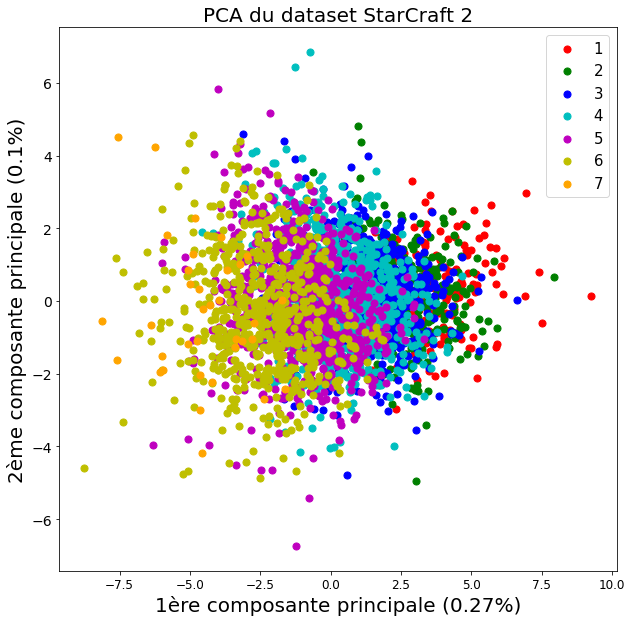

In [24]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('1ère composante principale'+' ('+str(round(pca.explained_variance_ratio_[0],2))+"%)",fontsize=20)
plt.ylabel('2ème composante principale'+' ('+str(round(pca.explained_variance_ratio_[1],2))+"%)",fontsize=20)
plt.title("PCA du dataset StarCraft 2",fontsize=20)
targets = [1,2,3,4,5,6,7]
colors = ['r','g','b','c','m','y','orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['LeagueIndex'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

### K-means

In [25]:
# Clustering

kmeans = KMeans(n_clusters=7) 
label=kmeans.fit_predict(principalComponents_data)

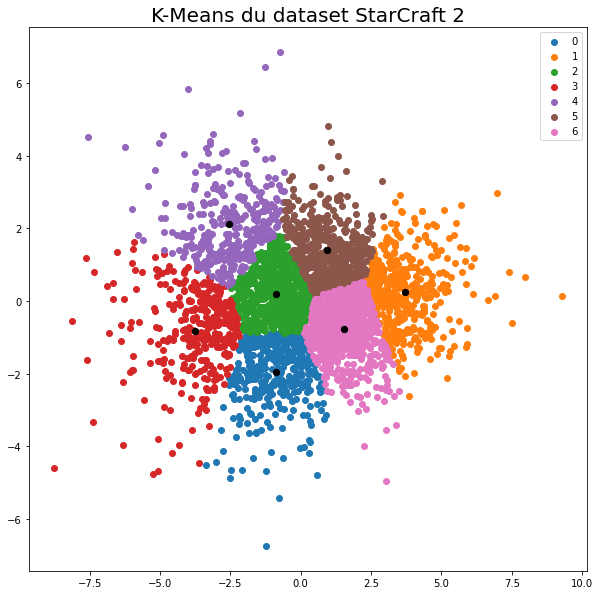

In [26]:
unique_labels = np.unique(label)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.title("K-Means du dataset StarCraft 2",fontsize=20)
for i in unique_labels:
    plt.scatter(principalComponents_data[label == i , 0] , principalComponents_data[label == i , 1] , label = i)
    
plt.scatter(centroids[:,0] , centroids[:,1] , s = 40, color = "k")
plt.legend()
plt.show()

## Prédictions

In [27]:
meilleursAttributs = ['APM','SelectByHotkeys', 'AssignToHotkeys', 'NumberOfPACs','GapBetweenPACs', 'ActionLatency']
x_features=x_scaled_df[meilleursAttributs]
x_features

,APM,SelectByHotkeys,AssignToHotkeys,NumberOfPACs,GapBetweenPACs,ActionLatency
0,0.607854,-0.106552,-0.687610,1.467259,-0.471974,-1.226970
1,0.306224,-0.151381,-0.498154,0.905697,-0.457217,-1.149303
2,-0.927943,-0.618608,-0.135535,-0.525541,0.230415,0.585187
3,-0.144178,-0.632936,-0.719036,0.362225,-0.674099,-0.550822
4,0.174180,-0.611200,-0.174816,-1.103146,-1.057066,-0.112274
...,...,...,...,...,...,...
3332,0.908134,2.081248,0.669186,0.155959,-0.253204,0.107918
3333,1.491017,0.622151,-0.019184,2.052346,-1.046922,-1.548842
3334,0.149368,-0.225159,-0.586789,0.265822,-0.301029,-0.328908
3335,0.411431,0.298233,-0.868894,-0.236414,-1.314796,-0.092296


In [28]:
y_target=data["LeagueIndex"]
y_target

0       5
1       5
2       4
3       3
4       3
       ..
3335    4
3336    5
3337    4
3338    3
3339    4
Name: LeagueIndex, Length: 3337, dtype: int64

### Naive Bayes

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.2)

bayes_model = GaussianNB()
bayes_model.fit(x_train, y_train)
y_pred=bayes_model.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print("Accuracy : ",accuracy_score(y_test, y_pred))


#entre 34 et 43%

[[17 17  2  2  0  0  0]
 [11 30 13  8  2  0  0]
 [ 8 30 29 20 17  2  0]
 [ 0 19 32 67 41  8  0]
 [ 0  4 17 37 61 39  2]
 [ 0  0  2 14 47 53  8]
 [ 0  0  0  0  0  7  2]]
Accuracy :  0.38772455089820357


In [30]:
bayes_model.predict(x_test[:1])

array([3])

### KNN

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.2)

knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model = knn_model.fit(x_train, y_train)
y_pred=knn_model.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print("Accuracy : ",accuracy_score(y_test, y_pred))


#entre 32 et 38%

[[ 4 11  3  2  2  0  0]
 [13 16 22 19  6  0  0]
 [ 6 21 32 44 16  3  0]
 [ 0  9 38 48 39 17  0]
 [ 0  2 19 45 55 43  0]
 [ 0  0  5 17 45 59  0]
 [ 0  0  0  0  1  6  0]]
Accuracy :  0.3203592814371258


### Decision Tree

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.2)

tree_model = DecisionTreeClassifier(splitter='best')
tree_model = tree_model.fit(x_train, y_train)
y_pred=tree_model.predict(x_test)
conf_mat=confusion_matrix(y_test, y_pred)
print(conf_mat)
print("Accuracy : ",accuracy_score(y_test, y_pred))

#entre 26 et 33% (vraiment pas terrible)

[[ 5  9 12  1  0  1  0]
 [ 6 17 16 13  9  2  0]
 [ 9 24 30 22 18  5  0]
 [ 4 13 43 60 31 20  0]
 [ 1  8 20 41 50 37  2]
 [ 1  4  9 18 53 49  1]
 [ 0  0  0  0  2  2  0]]
Accuracy :  0.3158682634730539


### Random Forests 

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.3)

clf = RandomForestClassifier(n_estimators=1000,max_features='sqrt',min_samples_leaf = 50 ) #cree la foret
clf = clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
conf_mat=confusion_matrix(y_test, y_pred)
print(conf_mat)
print("Accuracy : ",accuracy_score(y_test, y_pred))

#entre 35 et 41%

[[ 12  33   7   6   0   0   0]
 [  5  26  36  23   4   1   0]
 [  3  17  51  72  20   5   0]
 [  0  10  36 115  53  12   0]
 [  0   2  10  93  88  60   0]
 [  0   0   3  34  63  94   0]
 [  0   0   0   0   0   8   0]]
Accuracy :  0.3852295409181637


### TensorFlow

In [34]:
X=x_scaled_df
# ensure all data are floating point values
X = X.astype('float32')
y=data["LeagueIndex"]
y=y-1
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(7, activation = 'relu'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

(2235, 18) (1102, 18) (2235,) (1102,)


In [35]:
# fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=15, batch_size=10000)

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 5.9375 - accuracy: 0.2242 - val_loss: 4.8388 - val_accuracy: 0.2486
Epoch 2/15
1/1 [==============================] - 0s 51ms/step - loss: 5.0162 - accuracy: 0.2376 - val_loss: 4.3365 - val_accuracy: 0.2568
Epoch 3/15
1/1 [==============================] - 0s 49ms/step - loss: 4.3640 - accuracy: 0.2497 - val_loss: 3.8602 - val_accuracy: 0.2659
Epoch 4/15
1/1 [==============================] - 0s 52ms/step - loss: 3.8902 - accuracy: 0.2631 - val_loss: 3.4865 - val_accuracy: 0.2632
Epoch 5/15
1/1 [==============================] - 0s 43ms/step - loss: 3.5950 - accuracy: 0.2716 - val_loss: 3.2098 - val_accuracy: 0.2632
Epoch 6/15
1/1 [==============================] - 0s 52ms/step - loss: 3.3366 - accuracy: 0.2676 - val_loss: 3.0808 - val_accuracy: 0.2559
Epoch 7/15
1/1 [==============================] - 0s 40ms/step - loss: 3.1450 - accuracy: 0.2743 - val_loss: 2.9650 - val_accuracy: 0.2568
Epoch 8/15
1/1 [=============

In [36]:
model.predict(X_train[:1])

array([[0.        , 0.46796796, 0.12818979, 0.84930784, 0.559308  ,
        0.41740742, 0.183653  ]], dtype=float32)